# LIN Approximation Limitations using DUALEM-482

In [347]:
# Importing libraries
import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from IPython.display import Image

# Dualem Geometry

In [348]:
Image(url= "Dualem-Geometry.PNG", width=400, height=400)

In [567]:
# Define Dualem-482 geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
# Use H source
Preceivers = [offsets, offsets*0, height, 0, 0] # MUST FIX THIS
#Preceiver = [offsets, offsets, -rad, rad, height-rad, height+rad]

# Frequency
freq = 9000

In [568]:
# Define a homogeneous earth model

depth = [0]

# Define skin factor

sigma = 4/1000 # True conductivity in S/m

print('For a conductivity of: ', sigma*1000, 'mS/m')
print('and a device using a frequency of: ', freq, 'Hz')

delta = np.sqrt(2/(2 * np.pi * freq * mu_0 * sigma))
print('The skin factor is: ', delta)

# Define dimensionless induction number beta

beta = sigma / delta
print('Induction number is: ', beta)

For a conductivity of:  4.0 mS/m
and a device using a frequency of:  9000 Hz
The skin factor is:  83.8820201513134
Induction number is:  4.768602368880084e-05


In [577]:
Hs = empymod.loop(Hsource, Preceivers, depth=[0], res=[2e14,10], freqtime=freq, xdirect=None, mrec = 'loop', verb=1)
Hp  = empymod.loop(Hsource, Preceivers, depth=[], res=[10], freqtime=freq, mrec = 'loop', verb=1)
Hs/Hp

EMArray([-0.0001882 -9.98239282e-05j, -0.00135095+1.02142933e-03j,
         -0.00935198+1.09288151e-02j])

# Define function to calculate Quadrature using empymod

In [592]:
def SecondaryFieldQuadrature(src, rec, depth, sigma, freq):
    res_ground = 1/sigma # Resistivity in Ohm . m
    res_air = 2e14
    res= [res_air] + [res_ground]
    Hs = empymod.loop(src, rec, depth, res, freq, xdirect=None, mrec = 'loop', verb=1)
    Hp = empymod.loop(src, rec, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=1)
    Q = np.imag(Hs/Hp)
    return np.abs(Q)

# Low Induction Number approximation

$(\frac{Hs}{Hp}) \approx \frac{\omega \mu_0 s^2 \sigma}{4}$

### Then we have:

$\sigma_a \approx 4 * Q /(\omega * \mu_0 * s^2)$

- $\sigma_a$   -> Apparent Conductivity
- $\sigma$ -> True conductivity
- $Q$     -> Quadrature
- $\omega$ -> angular frequency
- $\mu_0$ -> magnetic permeability
- $s$     -> coil sepparation

In [593]:
# Function to calculate apparent conductivity according to LIN approximation

def Sigma_app_LIN(Q, freq, mu_0, s):
    sigma_app = 4 * Q / ((2 * np.pi * freq) * mu_0 * s**2)
    return sigma_app

# Example of $\sigma_{app}$ calculation for VCP coil

In [594]:
# Quadrature values for each coil

Q = SecondaryFieldQuadrature(Vsource, Vreceivers, depth, sigma, freq) 

In [595]:
print('The true conductivity is:', sigma*1000, 'mS/m')
print('Using the VCP configuration')
for s, quad in zip(offsets, Q):
    sigma_app = Sigma_app_LIN(quad, freq, mu_0, s)
    print('For a coil separation: ',s, 'meters, the apparent conductivity is: ', sigma_app*1000, 'mS/m')

The true conductivity is: 10.0 mS/m
Using the VCP configuration
For a coil separation:  2 meters, the apparent conductivity is:  8.849410221802886 mS/m
For a coil separation:  4 meters, the apparent conductivity is:  9.111596742540499 mS/m
For a coil separation:  8 meters, the apparent conductivity is:  8.95916978877657 mS/m


# LIN approximation for different $\sigma$ using the VCP coil

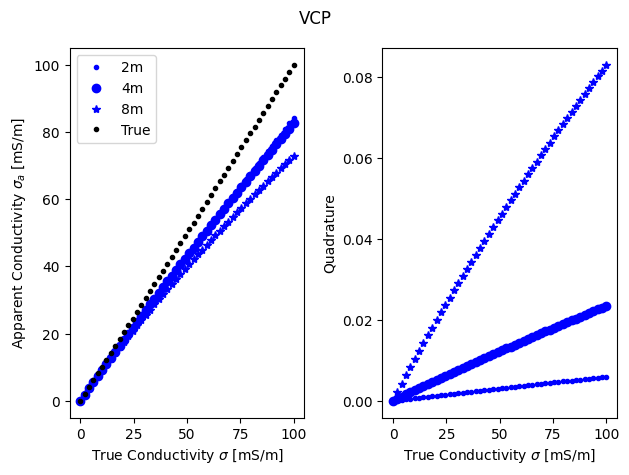

In [596]:
# Define a range of electrical conductivities to test

sigma_arr = np.linspace(0.001/1000, 100/1000) 

# Calculate the quadratures
Q_arr = []
for sigma in sigma_arr:
    Q = SecondaryFieldQuadrature(Vsource, Vreceivers, depth, sigma, freq)
    Q_arr.append(Q)
    
# Estimate apparent conductivities

sigma_est_2m = []
sigma_est_4m = []
sigma_est_8m = []

Q2_arr = []
Q4_arr = []
Q8_arr = []

for Quad in Q_arr:
    Q2= Quad[0]
    Q2_arr.append(Q2)
    sigma_est_2m.append(Sigma_app_LIN(Q2, freq, mu_0, 2))
    Q4= Quad[1]
    Q4_arr.append(Q4)
    sigma_est_4m.append(Sigma_app_LIN(Q4, freq, mu_0, 4))
    Q8= Quad[2]
    Q8_arr.append(Q8)
    sigma_est_8m.append(Sigma_app_LIN(Q8, freq, mu_0, 8))
    
# Create two subplots and unpack the output array immediately
fig, (ax1, ax2) = plt.subplots(1, 2,)
    
ax1.plot(sigma_arr*1000, np.array(sigma_est_2m)*1000, '.b', label ='2m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_4m)*1000, 'ob', label = '4m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_8m)*1000, '*b', label ='8m')
ax1.plot(sigma_arr*1000, sigma_arr*1000, '.k', label ='True')
ax1.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax1.set_ylabel('Apparent Conductivity $\sigma_a$ [mS/m]')
ax1.legend()


ax2.plot(sigma_arr*1000, Q2_arr, '.b', label = '2m')
ax2.plot(sigma_arr*1000, Q4_arr, 'ob', label = '4m')
ax2.plot(sigma_arr*1000, Q8_arr, '*b', label = '8m')
ax2.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax2.set_ylabel('Quadrature')

fig.suptitle('VCP')
fig.tight_layout()

# LIN approximation for different $\sigma$ using the HCP coil

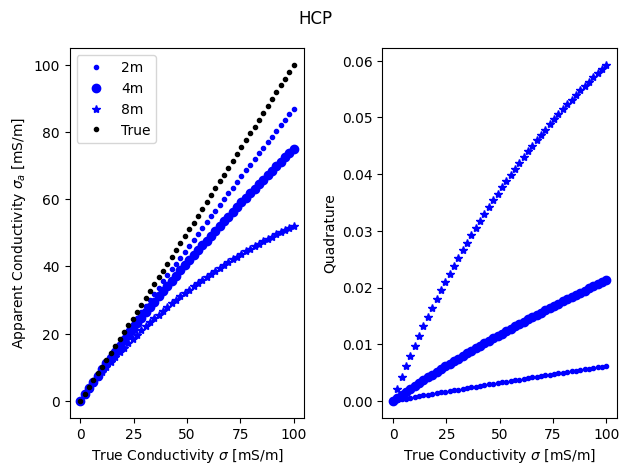

In [597]:
# Define a range of electrical conductivities to test
sigma_arr = np.linspace(0.001/1000, 100/1000) 

# Calculate the quadratures
Q_arr = []
for sigma in sigma_arr:
    Q = SecondaryFieldQuadrature(Hsource, Hreceivers, depth, sigma, freq)
    Q_arr.append(Q)

# Estimate apparent conductivities
sigma_est_2m = []
sigma_est_4m = []
sigma_est_8m = []

Q2_arr = []
Q4_arr = []
Q8_arr = []

for Quad in Q_arr:
    Q2= Quad[0]
    Q2_arr.append(Q2)
    sigma_est_2m.append(Sigma_app_LIN(Q2, freq, mu_0, 2))
    Q4= Quad[1]
    Q4_arr.append(Q4)
    sigma_est_4m.append(Sigma_app_LIN(Q4, freq, mu_0, 4))
    Q8= Quad[2]
    Q8_arr.append(Q8)
    sigma_est_8m.append(Sigma_app_LIN(Q8, freq, mu_0, 8))
    
# Create two subplots and unpack the output array immediately
fig, (ax1, ax2) = plt.subplots(1, 2,)
    
ax1.plot(sigma_arr*1000, np.array(sigma_est_2m)*1000, '.b', label ='2m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_4m)*1000, 'ob', label = '4m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_8m)*1000, '*b', label ='8m')
ax1.plot(sigma_arr*1000, sigma_arr*1000, '.k', label ='True')
ax1.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax1.set_ylabel('Apparent Conductivity $\sigma_a$ [mS/m]')
ax1.legend()


ax2.plot(sigma_arr*1000, Q2_arr, '.b', label = '2m')
ax2.plot(sigma_arr*1000, Q4_arr, 'ob', label = '4m')
ax2.plot(sigma_arr*1000, Q8_arr, '*b', label = '8m')
ax2.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax2.set_ylabel('Quadrature')

fig.suptitle('HCP')
fig.tight_layout()

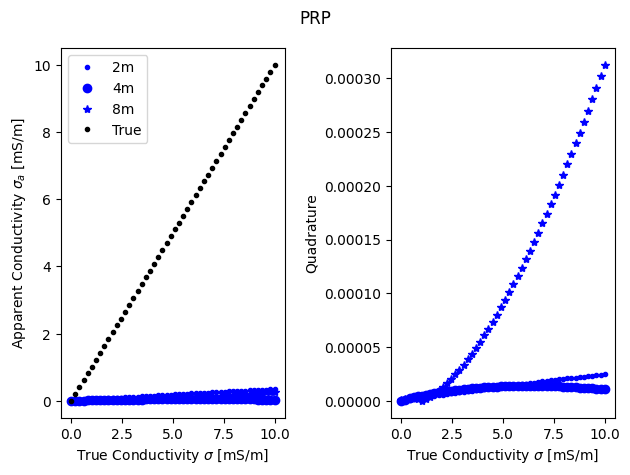

In [598]:
# Define a range of electrical conductivities to test
sigma_arr = np.linspace(0.001/1000, 10/1000) 
Q_arr = []
for sigma in sigma_arr:
    Q = SecondaryFieldQuadrature(Hsource, Preceivers, depth, sigma, freq)
    Q_arr.append(Q)

# Calculate the quadratures
sigma_est_2m = []
sigma_est_4m = []
sigma_est_8m = []

Q2_arr = []
Q4_arr = []
Q8_arr = []

for Quad in Q_arr:
    Q2= Quad[0]
    Q2_arr.append(Q2)
    sigma_est_2m.append(Sigma_app_LIN(Q2, freq, mu_0, 2))
    Q4= Quad[1]
    Q4_arr.append(Q4)
    sigma_est_4m.append(Sigma_app_LIN(Q4, freq, mu_0, 4))
    Q8= Quad[2]
    Q8_arr.append(Q8)
    sigma_est_8m.append(Sigma_app_LIN(Q8, freq, mu_0, 8))
    
# Create two subplots and unpack the output array immediately
fig, (ax1, ax2) = plt.subplots(1, 2,)
    
ax1.plot(sigma_arr*1000, np.array(sigma_est_2m)*1000, '.b', label ='2m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_4m)*1000, 'ob', label = '4m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_8m)*1000, '*b', label ='8m')
ax1.plot(sigma_arr*1000, sigma_arr*1000, '.k', label ='True')
ax1.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax1.set_ylabel('Apparent Conductivity $\sigma_a$ [mS/m]')
ax1.legend()


ax2.plot(sigma_arr*1000, Q2_arr, '.b', label = '2m')
ax2.plot(sigma_arr*1000, Q4_arr, 'ob', label = '4m')
ax2.plot(sigma_arr*1000, Q8_arr, '*b', label = '8m')
ax2.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax2.set_ylabel('Quadrature')

fig.suptitle('PRP')
fig.tight_layout()